In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()              
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
inspector.get_table_names()              
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
import datetime as dt
max_date = session.query(func.max(Measurement.date)).all()
print(max_date)

[('2017-08-23',)]


# Exploratory Climate Analysis

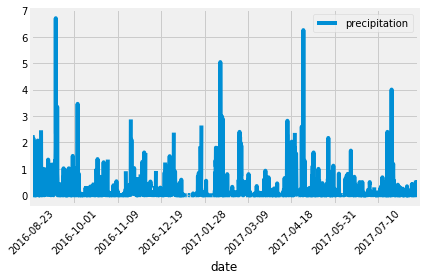

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

twelve_months_back = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
daily_precipitation = session.query(*sel).filter(Measurement.date >= twelve_months_back).all() 

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(daily_precipitation, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45)
plt.tight_layout()
plt.savefig('Images/precipitation.png')
plt.show()

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station)).all() 
stations

[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
daily_temp_station = session.query(*sel).filter(Measurement.station == "USC00519281").all() 
daily_temp_station

[(54.0, 85.0, 71.66378066378067)]

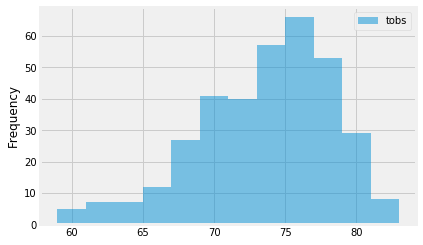

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.tobs]
#############DATE FILTER NOT WORKING daily_precipitation = session.query(*sel).filter(Measurement.date > twelve_months_back).group_by(Measurement.date).order_by(Measurement.date).all() 
daily_precipitation_station = session.query(*sel).filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= twelve_months_back).all() 

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(daily_precipitation_station, columns=['tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.hist(bins=12, alpha=0.5)
plt.savefig('Images/station-histogram.png')
plt.show()

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2018, 4, 18) - dt.timedelta(days=365)
end_date = dt.date(2018, 5, 1) - dt.timedelta(days=365)
TMIN, TAVE, TMAX = calc_temps(start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"))[0]
print(calc_temps(start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"))[0])

(58.0, 73.04494382022472, 83.0)


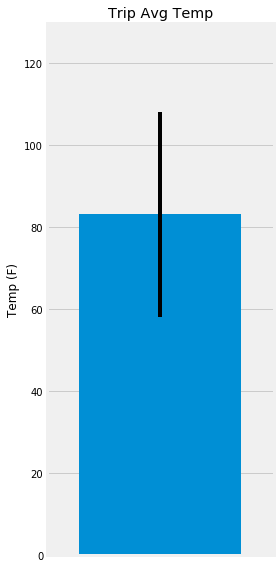

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
import datetime as dt
import numpy as np
    
ptps = 1
yerr = TMAX - TMIN
import numpy as np

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
ax.bar(ptps, TMAX, yerr=yerr, align='center')
ax.set(xticks=range(ptps), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.tight_layout()
plt.savefig('Images/temperature.png')
plt.show()


In [47]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 10.5), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 7.999999999999999), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 6.95), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 6.88), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 4.27), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.9200000000000002), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [53]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = dt.datetime.strptime('2018-04-18', "%Y-%m-%d")
end_date = dt.datetime.strptime('2018-05-01', "%Y-%m-%d")

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
trip_stripped = date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for trip_date in trip_stripped:
    normals.append(*daily_normals(trip_date))

normals

[(67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0),
 (65.0, 73.01818181818182, 79.0),
 (67.0, 73.3103448275862, 80.0),
 (66.0, 73.96551724137932, 83.0),
 (66.0, 74.01724137931035, 81.0),
 (65.0, 72.87272727272727, 81.0),
 (63.0, 73.46428571428571, 79.0),
 (66.0, 73.30357142857143, 81.0),
 (58.0, 71.5576923076923, 78.0),
 (65.0, 72.75925925925925, 79.0)]

In [54]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
normals_df['Date'] = pd.to_datetime(dt_list)
normals_df.set_index('Date', inplace=True)
normals_df

,tmin,tavg,tmax
Date,,,
2018-04-18,67.0,72.491525,77.0
2018-04-19,65.0,72.421053,83.0
2018-04-20,64.0,72.736842,80.0
2018-04-21,66.0,72.321429,78.0
2018-04-22,65.0,72.927273,84.0
2018-04-23,65.0,73.018182,79.0
2018-04-24,67.0,73.310345,80.0
2018-04-25,66.0,73.965517,83.0
2018-04-26,66.0,74.017241,81.0


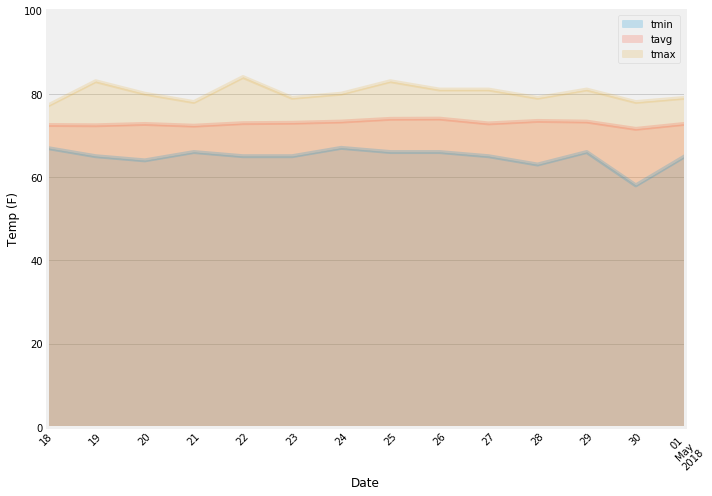

In [61]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha=0.2,figsize=(10,7), rot=45)
plt.ylabel('Temp (F)')
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('Images/daily-normals.png')
plt.show()